In [60]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"
from math import ceil

import time
import ipywidgets as widgets
from IPython.display import display

import numpy as np
import tensorflow as tf
from tensorflow.python.training.summary_io import SummaryWriterCache

import graph_manager
import net
import loss_utils
import tf_inputs
import tf_utils
import viz

import logging
logging.getLogger("tensorflow").setLevel(logging.WARNING)

### Define model to load

In [61]:
# Directory and  test TFRecords to evaluate on
log_dir = './log/vedai/odgi_512_256/06-05_23-34/'
test_tfrecords = './Data/vedai_test'
num_test_samples = 268
model = 'odgi'
# whether to output images with bounding boxes prediction
output_images = True
output_images_dir = os.path.join(log_dir, 'output_test')

# load and display configuration from the Tensorboard event file
event_files = list(filter(lambda x: x.startswith('event'), os.listdir(log_dir)))
assert len(event_files) == 1
event_file = os.path.join(log_dir, event_files[0])
configs = graph_manager.extract_config(event_file)
for k, c in configs.items():
    print(k)
    print('-------')
    print(', '.join('%s: %s' % (t, u) for t, u in c.items()))
    print()
    
# Number of eval iterations according to the default batch size in the configuration
if model == 'odgi':
    test_batch_size = configs['stage1']['batch_size'] * configs['stage1']['num_gpus']
    num_devices = configs['stage1']['num_gpus']
else:
    test_batch_size = configs['configuration']['batch_size'] * configs['configuration']['num_gpus']
    num_devices = configs['configuration']['num_gpus']
    
if num_test_samples % test_batch_size == 0:
    num_test_iters = num_test_samples // test_batch_size
else:
    num_test_iters = num_test_samples // test_batch_size + 1

stage2
-------
test_tfrecords: Data/vedai_test, num_threads: 8, base_log_dir: ./log, train_num_iters_per_epoch: 32, optimizer: ADAM, gpu_mem_frac: 1.0, offsets_margin: 0.025, group_classification_loss_weight: 1.0, num_filters: [16, 32, 64, 128, 256, 512, 1024], exp_name: vedai, feature_keys: ['im_id', 'num_boxes', 'bounding_boxes', 'classes'], test_patch_confidence_threshold: 0.25, weight_decay: 0.0, subset: -1, num_steps: 32032, confidence_loss_weight: 5.0, data_classes: ['camping car', 'car', 'others', 'pick-up', 'plane', 'ship', 'tractor', 'truck', 'van'], test_num_crops: 5, restore_replace_to: , retrieval_nms_threshold: 0.5, beta1: 0.9, train_tfrecords: Data/vedai_train, test_num_iters_per_epoch: 9, patch_nms_threshold: 0.25, train_max_num_bbs: 19, with_classification: False, test_num_samples: 268, base_name: stage2, patch_intersection_ratio_threshold: 0.3, batch_size: 16, train_patch_confidence_threshold: 0.15, target_conf_fn: iou, momentum: 0.9, offsets_loss_weight: 1.0, num_cell

### Predefine the metrics and corresponding normalization constant

In [62]:
if model == 'odgi':
    metrics_to_norm = {
        'stage2_avgprec_at0.25_eval': 'num_valid_samples_eval',
        'stage2_avgprec_at0.50_eval': 'num_valid_samples_eval',
        'stage2_avgprec_at0.75_eval': 'num_valid_samples_eval',
        'stage2_maxrecall_at0.25_eval': 'num_valid_samples_eval',
        'stage2_maxrecall_at0.50_eval': 'num_valid_samples_eval',
        'stage2_maxrecall_at0.75_eval': 'num_valid_samples_eval',
        'num_crops': 'num_samples_eval',
    }
elif model == 'standard':
    metrics_to_norm = {
        'tinyyolov2_avgprec_at0.25_eval': 'num_valid_samples_eval',
        'tinyyolov2_avgprec_at0.50_eval': 'num_valid_samples_eval',
        'tinyyolov2_avgprec_at0.75_eval': 'num_valid_samples_eval',
        'tinyyolov2_maxrecall_at0.25_eval': 'num_valid_samples_eval',
        'tinyyolov2_maxrecall_at0.50_eval': 'num_valid_samples_eval',
        'tinyyolov2_maxrecall_at0.75_eval': 'num_valid_samples_eval',
        'num_crops': 'num_samples_eval',
    }
else:
    raise ValueError('Unknown model name', model)

### Run evaluation metrics and outputs

In [63]:
def filter_op(op, op_basename):
    base = op_basename == op.type
    istest = 'eval' in op.name
    isrelevant = len(op.inputs) and sum(c in op.inputs[0].name for c in relevant_collections)
    return base and istest and isrelevant
    
with tf.Graph().as_default():
    # Import Graph
    meta_files = list(filter(lambda x: x.endswith('.meta'), os.listdir(log_dir)))
    assert len(meta_files) == 1
    saver = tf.train.import_meta_graph(
        os.path.join(log_dir, meta_files[0]),
        input_map={'eval/load_dataset/filenames:0': tf.convert_to_tensor(test_tfrecords)})
    
    # Collect metrics across devices
    metric_dict = {}
    num_samples = tf.add_n(tf.get_collection('num_samples_eval'))
    num_valid_samples = tf.add_n(tf.get_collection('num_valid_samples_eval'))
    for metric_key, norm_key in metrics_to_norm.items():
        metric = tf.add_n(tf.get_collection(metric_key))
        norm = tf.add_n(tf.get_collection(norm_key))
        metric_dict[metric_key] = metric / tf.maximum(1., tf.to_float(norm))
        
    # Collect metrics update and clear operations
    relevant_collections = list(set(list(metrics_to_norm.keys()) + list(metrics_to_norm.values())))

    update_op = tf.group(*[op for op in tf.get_default_graph().get_operations() 
                           if filter_op(op, 'AssignAdd')])
    clear_op = tf.group(*[op for op in tf.get_default_graph().get_operations() 
                          if filter_op(op, 'Assign')])
    
    # Create output images with confidence > 0.5 + non maximum suppression
    if output_images:
        # collect tensor
        input_images = []
        output_scores = []
        output_boxes = []
        images_ids = []
        for d in range(num_devices):
            output_scores.append(tf.get_default_graph().get_tensor_by_name(
                'eval/dev%d/eval/filter_confidence/mul:0' % (d)))
            output_boxes.append(tf.get_default_graph().get_tensor_by_name(
                'eval/dev%d/eval/filter_confidence/mul_1:0' % (d)))
            images_ids.append(tf.get_default_graph().get_tensor_by_name(
                'eval/create_inputs/im_id_device0%s:0' % ('' if d == 0 else ('_%d' % d))))
            input_images.append(tf.get_default_graph().get_tensor_by_name(
                'eval/create_inputs/image_device1%s:0' % ('' if d == 0 else ('_%d' % d))))
        input_images = tf.concat(input_images, axis=0)
        output_boxes = tf.concat(output_boxes, axis=0)[:, 0, :, :]
        output_scores = tf.reduce_max(tf.concat(output_scores, axis=0), axis=1)
        images_ids = tf.concat(images_ids, axis=0)
        # filter scores
        filtered = tf.to_float(output_scores > 0.5)
        output_scores *= filtered
        output_boxes *= tf.expand_dims(filtered, axis=-1)
        # apply nms        
        final_boxes = []
        for i in range(test_batch_size):
            final_boxes.append(
                tf_utils.nms_with_pad(output_boxes[i, :, :], output_scores[i, :], 1024)[0])
        final_boxes = tf.stack(final_boxes, axis=0)
        # draw
        images = viz.draw_bounding_boxes(input_images, final_boxes)
    
    # Run session
    config = tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=1.),
                        log_device_placement=True, allow_soft_placement=True)
    with tf.train.MonitoredTrainingSession(config=config) as sess:
        weight_file = tf.train.latest_checkpoint(log_dir)
        saver.restore(sess, weight_file)
        print('Evaluate %s on TFRecords:' % model, test_tfrecords)      
        print('Load latest checkpoint from', log_dir)
        print(num_test_iters, 'test iterations to process', num_test_samples, 'test samples')        
        if output_images:
            from matplotlib import image as mpimg
            if not os.path.exists(output_images_dir):
                os.makedirs(output_images_dir)
        
        # Pass through te dataset
        sess.run(clear_op)
        for i in range(num_test_iters):
            print('\r%d/%d' % (i + 1, num_test_iters), end='')
            # Compute metric
            sess.run(update_op)
            # Store images
            if output_images:
                images_, images_ids_ = sess.run([images, images_ids])
                for image_, image_id_ in zip(images_, images_ids_):
                    if image_id_ > 0:
                        mpimg.imsave(os.path.join(output_images_dir, '%s.jpg' % image_id_), image_)
                    
        # Print metrics
        metric_dict_ = sess.run(metric_dict)
        print()
        print('Procesed', sess.run(num_samples), 'samples')
        print('which includes', sess.run(num_valid_samples), 'non-empty ones')
        
        print('\nResults:')
        print('-------')
        keys = sorted(metric_dict_.keys())
        print('\n'.join('\x1b[32m%s\x1b[0m: %s' % (k, metric_dict_[k]) for k in keys))

Evaluate odgi on TFRecords: ./Data/vedai_test
Load latest checkpoint from ./log/vedai/odgi_512_256/06-05_23-34/
9 test iterations to process 268 test samples
9/9
Procesed 268.0 samples
which includes 262.0 non-empty ones

Results:
-------
num_crops: 2.55224
stage2_avgprec_at0.25_eval: 0.717833
stage2_avgprec_at0.50_eval: 0.643739
stage2_avgprec_at0.75_eval: 0.280844
stage2_maxrecall_at0.25_eval: 0.792599
stage2_maxrecall_at0.50_eval: 0.728819
stage2_maxrecall_at0.75_eval: 0.327047


Display saved images


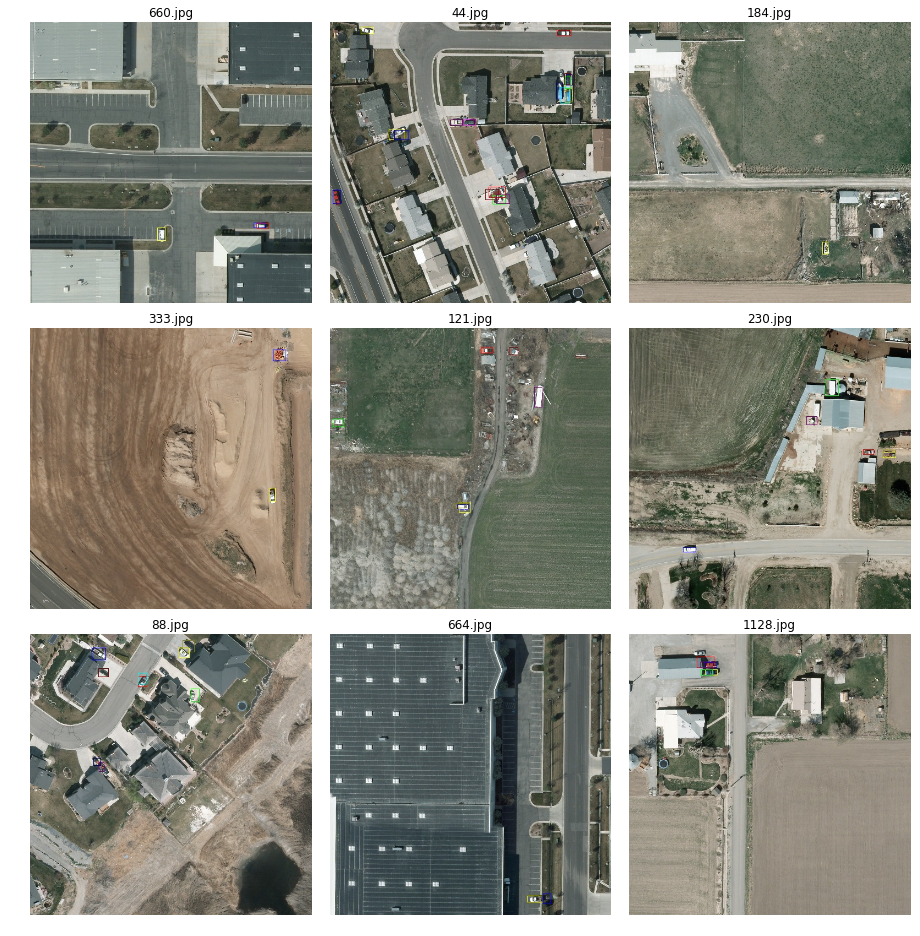

In [70]:
from matplotlib import pyplot as plt
print('Display saved images')
images = [os.path.join(output_images_dir, f) for f in os.listdir(output_images_dir) if f.endswith('.jpg')]
f, axis = plt.subplots(3, 3, figsize=(16, 16))
np.random.shuffle(images)
for ax, img in zip(axis.flatten(), images[:9]):
    ax.imshow(mpimg.imread(img))
    ax.set_title(img.rsplit('/', 1)[1])
    ax.set_axis_off()
plt.subplots_adjust(wspace=0.02, hspace=0.09)
plt.show()